# Test with the first dataset

In [2]:
import pyham
from Bio import SeqIO
import os
import matplotlib.pyplot as plt

# Path to nwk file
nwk_path = "./data/events/RealTree.nwk"

# The newick tree is extracted as a string
tree_str = pyham.utils.get_newick_string(nwk_path, type="nwk")

# Path to OrthoXML file
orthoxml_path = "./data/events/hogs.orthoxml"

#ham_analysis = pyham.Ham(tree_str, orthoxml_path, use_internal_name=True)
ham_analysis_no_name = pyham.Ham(tree_str, orthoxml_path, use_internal_name=False)

In [3]:
def locus_to_id(file):
    
    """
    This function extracts loci from a fasta file and store the information as keys in a dictionary 
    and the related protein ID as value.

    Args:
        file (:obj:`str`): path to the file of interest.

    Returns:
        a dictionary mapping locus (:obj:`str`) with protein ID (:obj:`str`).
    """
    
    locus_to_id = {}
    for seq_record in SeqIO.parse(file, 'fasta'):
        locus_to_id[int(seq_record.description.split('locus: ')[-1])] = seq_record.id[:-1]
            
    return locus_to_id

In [4]:
def get_locus(directory):
    
    """
    This function goes through each file of a folder and build a dictionary containing loci 
    as keys and the related protein ID as values. For each entry in the dictionary, the function 
    updates the corresponding :obj:`pyham.abstractgene.Gene` by adding its locus.

    Args:
        directory (:obj:`str`): directory of interest.

    Returns:
        xxx
    """

    path = directory
    for file in os.listdir(path):
        path_to_file = path + '/' + file
        locus_dictionary = locus_to_id(path_to_file)
 
        for entry in locus_dictionary:
            gene = ham_analysis_no_name.get_genes_by_external_id(locus_dictionary[entry])
            for element in gene:
                element.locus = entry
                
        ham_analysis_no_name.get_extant_genome_by_name(file[:-6]).locus_assignment = True

In [5]:
get_locus('/Users/karimsaied/Documents/biology/master/mls_2018/master_project/data/events/DB')

In [6]:
def get_gene_by_locus(genome, locus):
    
    """
    Get a :obj:`pyham.abstractgene.Gene` that match the query locus. 

    Args:
        genome (:obj:`pyham.genome.Genome`): extant genome of interest.
        locus (:obj:`int`): locus

    Returns:
        :obj:`pyham.abstractgene.Gene`
    """
    
    for gene in genome.genes:
        if gene.locus == locus:
            return gene 
    
    return None

In [7]:
def assign_neighbors(genome):
    
    """
    This function assigns a left and right neighbor to each :obj:`pyham.abstractgene.Gene` 
    or :obj:`pyham.abstractgene.HOG`.

    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.

    Returns:
        xxx
    """
    
    if isinstance(genome, pyham.ExtantGenome):
        
        for extant_gene in genome.genes:
            extant_gene.neighbors = (get_gene_by_locus(genome, extant_gene.locus-1), 
                                     get_gene_by_locus(genome, extant_gene.locus+1))  # Tuple to be handle by set further            
                        
    if isinstance(genome, pyham.AncestralGenome):
    
        for ancestral_gene in genome.genes:  # For each HOG in the ancestral genome...
            
            tmp = set()
            
            for child in ancestral_gene.children:  # For each HOG, their children are considered
                
                for neighbor in child.neighbors:
                    if neighbor == None:
                        tmp.add(None)
                        
                    else:
                        tmp.add(neighbor.parent)
                        
            if len(tmp) == 2:  # If all neighbors have the same parent
                ancestral_gene.neighbors = tuple(tmp)  # Extraction of the neighbors from the set
            
            elif len(tmp) == 3 and None in tmp:  # If children have different neighbors
                tmp2 = list(tmp)
                tmp2.remove(None)
                ancestral_gene.neighbors = tuple(tmp2)
                
            else:
                ancestral_gene.neighbors = (None, None)


In [43]:
print(genome1_4.genes[116])
print(genome1_4.genes[116].neighbors)

print('Children: {}'.format(genome1_4.genes[116].children))
print('\n')
for child in genome1_4.genes[116].children:
    print('Child: {}'.format(child))
    print(child.neighbors)
print('\n')
for child in genome1_4.genes[116].children:
    print('Child: {}'.format(child))
    print(child.neighbors[0].parent)
    print(child.neighbors[1].parent)
    print('\n')

<HOG(117)>
(<HOG(117)>, <HOG(2)>)
Children: [Gene(3097), Gene(104), Gene(947)]


Child: Gene(3097)
(Gene(3722), Gene(3098))
Child: Gene(104)
(Gene(727), Gene(947))
Child: Gene(947)
(Gene(104), Gene(105))


Child: Gene(3097)
<HOG(2)>
None


Child: Gene(104)
<HOG(2)>
<HOG(117)>


Child: Gene(947)
<HOG(117)>
None




In [17]:
print(genome1_4.genes[24])
print(genome1_4.genes[24].neighbors)

print('Children: {}'.format(genome1_4.genes[24].children))
print('\n')
for child in genome1_4.genes[24].children:
    print('Child: {}'.format(child))
    print(child.neighbors)
print('\n')
for child in genome1_4.genes[24].children:
    print('Child: {}'.format(child))
    print(child.neighbors[0].parent)
    print(child.neighbors[1].parent)
    print('\n')

<HOG(25)>
(<HOG(25)>, <HOG()>)
Children: [Gene(307), Gene(3981), Gene(3301)]


Child: Gene(307)
(Gene(751), Gene(670))
Child: Gene(3981)
(Gene(3301), Gene(3302))
Child: Gene(3301)
(Gene(3748), Gene(3981))


Child: Gene(307)
<HOG()>
None


Child: Gene(3981)
<HOG(25)>
None


Child: Gene(3301)
<HOG()>
<HOG(25)>




In [75]:
def get_synteny_blocks(genome):
    
    """
    This function aims to reconstruct the synteny blocks using the left and right 
    neighbors of :obj:`pyham.abstractgene`.

    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.

    Returns:
        list of lists that contain :obj:`pyham.abstractgene.Gene` or 
        :obj:`pyham.abstractgene.HOG` in a specific order.
    """

    syn_blocks = []
    seen = []
    gene_collection = genome.genes
    tmp = []
    
    #print('Processing genome {}'.format(genome.name))
    
    for abstract_gene in gene_collection:
        if abstract_gene in seen:
            continue
        
        #print(gene_collection.index(abstract_gene))
        
        block1 = []
        block2 = []
        
        current1 = abstract_gene
        current2 = abstract_gene  # Used for the block2
        
        block1.append(current1)  # [X] where X is the first abstract gene
        seen.append(current1)
        
        # First end (block1)
        next_gene = current1.neighbors[0]
            
        while next_gene != None:
            if next_gene in seen:
                next_gene = None
                continue
            
            #print(id(next_gene))
            previous = current1
            current1 = next_gene
            
            if previous in current1.neighbors:  # Does the previous gene (E) belong to the neighbors of d?
                block1.append(current1)
                seen.append(current1)
            
            if previous == current1.neighbors[0]:
                next_gene = current1.neighbors[1]
            else:
                next_gene = current1.neighbors[0]

        # Second end (block2)
        next_gene = current2.neighbors[1]
            
        while next_gene != None:
            if next_gene in seen:
                next_gene = None
                continue
            
            previous = current2
            current2 = next_gene
            
            if previous in current2.neighbors:
                block2.append(current2)
                seen.append(current2)
            
            if previous == current2.neighbors[0]:
                next_gene = current2.neighbors[1]
            else:
                next_gene = current2.neighbors[0]
        
        syn_blocks.append(block1[::-1] + block2)
        
    genome.synteny = syn_blocks

### Test with one ancestral genome

In [55]:
anc_genome = ham_analysis_no_name.get_ancestral_genome_by_name('SE008/SE018/SE011')
print('Previous: {}'.format(id(anc_genome.genes[151])))  # previous (abstract_gene)
print('Current1: {}'.format(id(anc_genome.genes[151].neighbors[0])))  # current1
print(anc_genome.genes[151] in anc_genome.genes[151].neighbors[0].neighbors)
print(anc_genome.genes[151] == anc_genome.genes[151].neighbors[0].neighbors[0])
print(id(anc_genome.genes[151].neighbors[0].neighbors[0]))
print(id(anc_genome.genes[151].neighbors[0].neighbors[1]))
print('\n')

print('Previous: {}'.format(id(anc_genome.genes[151].neighbors[0])))  #previous
print('Current1: {}'.format(id(anc_genome.genes[151].neighbors[0].neighbors[0])))  # current1
print(anc_genome.genes[151].neighbors[0] in anc_genome.genes[151].neighbors[0].neighbors[0].neighbors)
print(anc_genome.genes[151].neighbors[0] == anc_genome.genes[151].neighbors[0].neighbors[0].neighbors[0])
print(id(anc_genome.genes[151].neighbors[0].neighbors[0].neighbors[0]))
print(id(anc_genome.genes[151].neighbors[0].neighbors[0].neighbors[1]))
print('\n')

print('Previous: {}'.format(id(anc_genome.genes[151].neighbors[0].neighbors[0])))  # previous
print('Current1: {}'.format(id(anc_genome.genes[151].neighbors[0].neighbors[0].neighbors[1])))  # current1
print(anc_genome.genes[151].neighbors[0].neighbors[0] in anc_genome.genes[151].neighbors[0].neighbors[0].neighbors[1].neighbors)
print(anc_genome.genes[151].neighbors[0].neighbors[0] == anc_genome.genes[151].neighbors[0].neighbors[0].neighbors[1].neighbors[0])
print(id(anc_genome.genes[151].neighbors[0].neighbors[0].neighbors[1].neighbors[0]))
print(id(anc_genome.genes[151].neighbors[0].neighbors[0].neighbors[1].neighbors[1]))


Previous: 4646467232
Current1: 4648447112
True
False
4647314824
4646467232


Previous: 4648447112
Current1: 4647314824
True
True
4648447112
4646467232


Previous: 4647314824
Current1: 4646467232
False
False
4648447112
4651179144


In [9]:
genome1 = ham_analysis_no_name.get_extant_genome_by_name('SE001')
genome4 = ham_analysis_no_name.get_extant_genome_by_name('SE004')

genome1_4 = ham_analysis_no_name.get_ancestral_genome_by_name('SE001/SE004')

assign_neighbors(genome1)
assign_neighbors(genome4)
assign_neighbors(genome1_4)

get_synteny_blocks(genome1_4)
#genome1_4.synteny

Processing genome SE001/SE004
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
30
31
33
34
35
37
38
39
40
41
42
43
44
45
46
47
48
50
51
52
53
55
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
75
76
77
79
80
81
82
83
84
85
86
87
88
89
90
92
93
94
95
96
97
98
100
101
102
104
105
106
107
109
110
111
112
113
114
118
119
120
121
122
123
124
125
126
129
130
131
132
133
134
135
136
137
138
139
140
142
143
144
145
146
147
148
149
151
152
154
155
156
157
158
159
160
161
162
163
164
167
168
169
170
171
172
173
174
176
177
180
181
182
183
184
185
186
188
189
190
191
192
193
194
195
196
197
199
200
201
202
206
207
208
209
210
211
212
214
216
217
218
221
222
223
224
225
226
227
228
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
254
255
257
258
259
260
261
262
263
264
265
267
268
269
270
271
272
273
274
275
276
277
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
300
301
302
303
304
305
306
307
308
3

[[<HOG()>, <HOG(30)>, <HOG()>, <HOG()>, <HOG()>, <HOG(1)>, <HOG()>, <HOG()>],
 [<HOG(37)>,
  <HOG()>,
  <HOG(33)>,
  <HOG(55)>,
  <HOG(57)>,
  <HOG(2)>,
  <HOG(117)>,
  <HOG(117)>,
  <HOG(2)>,
  <HOG(57)>,
  <HOG(55)>,
  <HOG(33)>,
  <HOG()>,
  <HOG(37)>],
 [<HOG(3)>],
 [<HOG(4)>],
 [<HOG(5)>],
 [<HOG(6)>],
 [<HOG(7)>],
 [<HOG(8)>],
 [<HOG(9)>],
 [<HOG(58)>, <HOG(10)>, <HOG()>],
 [<HOG(11)>],
 [<HOG(12)>],
 [<HOG(13)>],
 [<HOG(14)>],
 [<HOG(15)>],
 [<HOG(79)>, <HOG()>, <HOG(16)>],
 [<HOG(17)>],
 [<HOG(18)>],
 [<HOG(19)>],
 [<HOG(75)>, <HOG()>, <HOG(20)>],
 [<HOG(109)>, <HOG(21)>],
 [<HOG()>, <HOG()>, <HOG(22)>],
 [<HOG()>, <HOG()>, <HOG(50)>, <HOG(23)>],
 [<HOG(24)>],
 [<HOG()>, <HOG(25)>, <HOG(25)>, <HOG()>],
 [<HOG(26)>],
 [<HOG(27)>],
 [<HOG(28)>],
 [<HOG(29)>],
 [<HOG(31)>, <HOG()>],
 [<HOG(32)>, <HOG()>, <HOG()>],
 [<HOG(34)>],
 [<HOG(35)>],
 [<HOG(36)>, <HOG()>, <HOG()>],
 [<HOG(38)>],
 [<HOG(39)>],
 [<HOG(40)>],
 [<HOG()>, <HOG(41)>, <HOG()>],
 [<HOG(42)>],
 [<HOG(43)>, <HOG()>,

### Sanity check

In [10]:
print(len(genome1_4.genes))
counter = 0
for block in genome1_4.synteny:
    for hog in block:
        counter += 1

print(counter)

882
900


/!\ Warning, more HOG in genome.synteny than the length of the genome! /!\

Some HOGs are counted several times!

### Processing

In [71]:
for node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
    assign_neighbors(node.genome)
    get_synteny_blocks(node.genome)

Processing genome SE001
0
Processing genome SE004
0
Processing genome SE001/SE004
0
4649786000
4651497456
4651440336
4645344704
4651361000
4648558488
1
4645360416
4645360192
4645345040
4647128536
4645345600
4652687144
2
3
4
5
4651363464
6
7
8
4648924944
9
4645360528
4647096560
10
11
12
13
14
15
4652577960
4645363328
4650781888
16
4645383472
17
18
19
4650125744
4645362880
4645381960
20
4645383808
4651919176
21
4650911504
4651068384
4651120008
22
4645347224
4652894920
4650593136
4651496280
23
4651120008
24
25
26
27
28
30
4645361536
31
4648714760
33
34
35
4647256528
37
38
39
40
4647767960
4652129584
41
4651605016
42
4647626848
43
44
45
4649561224
46
47
4649966896
48
4651227400
50
51
4647502344
52
53
4647976128
55
58
4649964432
4652785168
4648000648
59
4652612632
60
61
62
4651997952
63
4649324104
4651629368
4652162800
64
65
66
4649561224
67
68
69
70
71
4647016096
4647232568
4647448192
4647659728
4652711888
4649035312
4647287552
72
73
75
4652635696
4652635584
76
77
79
4652080712
4651067152


372
376
4650272696
380
381
391
393
394
395
4648422760
396
409
4650325776
410
413
417
421
426
4651627072
429
431
432
433
436
449
453
472
477
480
481
482
483
496
4650833792
4652446496
499
500
4651204000
503
504
508
509
510
515
516
519
526
4651042128
527
529
530
531
534
4652998328
539
540
551
4652841672
4651602160
4651602048
553
554
568
569
570
4652259368
575
576
577
4649935144
578
581
4651066144
4651065976
589
591
593
596
598
605
608
613
616
621
622
623
624
627
633
635
4652744656
637
640
647
648
651
653
656
658
659
661
662
4650641448
4651602048
665
666
672
4651681552
4652367096
4651286424
4652340560
673
678
683
686
692
693
702
708
716
717
4651153168
718
719
720
4651228744
724
725
727
729
730
4651255344
735
740
743
754
761
763
768
772
773
777
779
785
788
794
798
800
801
803
807
820
821
4651997896
823
827
834
835
4652103552
836
837
838
4652127792
844
854
855
858
859
4652310824
860
861
867
868
871
875
876
879
890
891
892
900
901
902
908
911
913
917
938
943
944
945
948
951
954
955
956
957
46

4646803552
4647504472
4648445992
4646760288
143
4652811208
4648111240
4650486976
4652610784
144
147
149
150
151
4648447112
4647314824
153
154
4652105232
156
4649587544
4650463808
4652236584
157
4646733192
158
4646520816
4651332608
4647815936
4647816944
4649453552
4647764600
4647735248
4650643184
4647814704
160
4646650040
162
164
167
168
169
170
4648556640
4648557648
173
174
175
176
177
4650695704
4648750664
4648818896
179
183
184
186
187
188
189
190
4649188488
191
4647921480
4647920752
192
4652399808
193
194
195
4646784136
196
197
4650382896
4648557648
198
201
4650068904
4650096288
4652340784
4651307192
4652367320
4651681832
4652102880
202
4648605064
4652637712
4652636704
4652578800
204
4649403952
4649830608
4652759192
4652758408
4651998512
4652020400
209
211
213
4653131592
214
217
221
223
224
226
4649147976
227
4652481560
4652482400
4650094832
4651867552
4649705144
4650571480
230
4647047296
231
234
4647076920
235
236
237
4651629200
4652840496
238
4648055080
4649374664
4650353160
46523

4652159272
4648421920
317
324
4647868736
325
326
333
4651256968
4649323432
340
4649805752
4649965160
341
4652294040
345
346
4648926848
4648903064
347
4649374888
349
354
355
358
363
364
4649854120
4652480664
4648419400
365
367
368
369
370
4651285248
4651284184
374
4650435640
382
4651758592
383
386
387
388
395
397
404
4648952776
410
4650913576
418
421
424
436
4653081992
4652529200
4652528192
440
444
445
447
450
458
464
465
466
467
468
469
473
4650859992
475
476
479
483
484
4650097576
486
487
488
489
490
493
498
499
500
4651463624
4651462728
4649506184
501
502
503
504
4651630096
4652183904
508
524
531
4652021800
4652020624
4651998904
532
534
537
538
540
541
542
543
544
548
549
4652842120
4651602888
551
561
576
577
579
4650985232
580
585
588
596
598
599
603
610
611
613
622
627
637
644
647
648
4651520184
653
656
657
660
4651656584
662
663
664
668
4651866656
669
670
686
692
693
696
697
701
707
709
4650985232
710
712
714
719
721
733
734
735
738
744
745
750
753
754
755
758
760
762
4651465696
7

4652997712
106
4648714648
4648692928
4648692200
4646888560
4646367920
4651865648
4652950472
4648032072
4646251600
4648082568
4648082120
4646184104
4651068160
4652102208
4646547016
113
4649247016
4653052424
4648445208
4648445152
4650617432
115
4647473728
4646679272
4647233520
4646312872
4647017048
121
4649085584
4650466776
4650325440
4649249648
4649267552
122
124
4650245256
4647902344
4647901616
128
4650146952
4648184352
4648184464
4648183008
4649854344
4652480888
4648419624
4646925648
4651891176
4647422216
4649614136
4649614080
4649084352
4650860216
4650485632
4650594256
4649353904
4652184128
4649426280
4653028912
4647447800
4653108472
4648691080
4652445936
4650274656
4651680824
134
136
4648030896
140
142
4648799760
155
4651179704
4646889568
4650125408
4650124568
4650123728
4651015976
4651041344
4649405968
4649423760
4651921248
4652364520
4650041808
4647975792
4649806032
4649807040
4649965384
4647708600
4652399752
4646759504
159
168
169
4651733848
4649586872
4648348920
4653027680
176
4

4649147416
4649615200
4649376176
4651839560
4651204504
16
4648316656
4649889072
4649268112
4649267496
17
4651548856
4647015816
4649855688
4649856528
4646634776
4646633880
4649702176
4646544832
4646782232
4648235696
19
4650538936
4648313968
4650126472
4646156720
20
21
4647791976
22
4645632152
4652554672
4646441760
4649355080
23
24
4647047688
4647017944
4646733696
4646519360
4652655952
4650221920
4651201256
4646756424
4648400096
4649966616
4649703408
4649704416
4652185528
25
4651384224
4649507752
4647899208
4647100088
4647079720
4651628976
4652840888
4649647968
27
4647734184
4646991688
4646108856
4646107848
4652893072
28
4645846152
4646227752
4646397208
4648799704
4649612456
4646105720
4647016992
4646312816
4647233464
4646679216
4647473672
4646200600
4647660456
4652741520
4649036152
4647288560
4647314040
4649017296
4649936712
4649935760
4649934920
4649909216
4649377352
4646311808
4652612296
4646025312
4651381760
4651381032
4649990576
4653168848
4650665240
4648905808
4650835808
4650273480

4651918448
4651948016
4652868384
98
4650143928
99
4647625000
4647554072
4647577584
4647576016
100
4647016712
4646312536
4647233184
4646678880
4647473392
4646200320
4647660232
4652741240
4649035872
4647288224
4647313760
4649017016
4649936432
4649935424
4649910000
4649908880
4649377072
4646311584
4652611904
102
103
4646991408
4647733848
105
4646136520
4646202392
4646203344
4646545560
4650808432
4651961704
107
4653053880
4647868624
108
4646443720
4650435472
120
4649085248
4650466440
4650325104
4649249368
4649250768
123
4650244920
4647901952
4647901224
4648581104
4648555464
4652413056
4647336200
125
4652205336
4652206288
4652233840
4646834528
4650069016
4650096400
4652340896
127
132
141
144
149
151
4648447168
4647314936
152
153
4650590504
154
4652105400
4648979704
4649013320
4647127976
4646870600
4649886216
4652259760
159
175
176
4650695816
4650722304
4650721464
184
189
4648606240
4649481048
4649589840
4649588888
4649354856
190
4652399360
4647708264
4649965048
191
193
4646783688
4652578912

4648976456
4652839096
4652814232
442
443
445
447
4648818840
448
449
450
455
4651657480
475
488
494
499
500
501
4649298744
504
505
506
517
518
535
546
547
551
563
564
4649806536
565
567
571
574
575
4651817560
585
587
588
607
610
614
617
631
636
637
644
648
659
4653105616
669
678
679
680
684
4652102824
4652103664
689
4652556128
693
694
4651282616
4651013008
699
701
703
704
706
712
4650934168
713
714
716
720
726
4651522368
748
752
755
756
4651285080
757
761
766
771
772
784
787
795
798
801
802
805
818
821
830
838
839
840
842
4651961536
843
845
848
854
856
861
4652127960
862
871
874
888
891
893
894
897
910
914
915
935
951
956
960
964
967
970
981
Processing genome SE007/SE008/SE018/SE011/SE009/SE015/SE016/SE013/SE010/SE012/SE019/SE014/SE017
0
4648630480
4645996864
4648371704
1
4652342072
4646469584
4650573776
2
4649829544
4649887448
3
4645542712
4646734200
4647208776
4651658544
4646704968
4
5
4652553104
4649785216
6
4645686408
4652398072
4649036936
7
4646867520
4646869536
4645684168
46455837

4650757200
4650224496
321
322
4651042184
324
326
331
332
4652783096
4650966488
333
4647868288
335
337
4650986688
338
4647901840
339
342
4651256576
344
345
346
347
348
4650020648
351
352
354
4649034416
4649058768
4649118240
4649117232
355
356
358
360
361
366
367
371
4648183456
4650146280
377
381
383
384
387
4651154344
4651228800
388
389
4651414024
4651758312
4651759152
4651734408
4653054832
391
393
4650467224
397
398
400
401
402
407
408
4652187488
4651918112
409
410
411
4649268784
412
414
417
419
425
426
429
430
4653107856
436
437
438
4649060616
439
441
442
4648771256
443
4648797352
4649988952
444
446
448
456
457
462
463
467
474
4652740904
479
480
483
484
490
491
497
498
499
4651119000
502
503
4650833848
506
507
508
4651256576
510
512
513
515
516
518
519
520
522
526
527
531
532
533
4651042184
535
536
537
538
539
4651733120
4650519744
544
549
4649675744
4649991584
555
4652841728
4651602216
556
4650436928
4650437712
4651520856
562
565
566
567
568
569
577
580
581
582
4649936152
583
584
465

161
162
163
169
4648581776
4649355640
170
171
172
174
175
177
4651200584
4650196272
178
179
4648605848
4649480600
183
4652578464
184
4650383512
4651572808
185
186
188
189
4646835144
4650068512
191
4649743360
4649742408
4649725008
192
193
4649403672
198
199
4648693152
201
4647706752
4650464816
4651522088
4651439384
4650932712
202
4652554112
203
204
4650617936
205
206
207
4651891288
4647421432
4649612792
4649083456
210
211
214
4652710768
215
4651787264
4651787600
4647422664
4647423728
4647366496
4648846616
217
4649146576
4649375448
218
4650069800
220
222
224
225
226
228
4647190144
229
230
231
232
233
235
4649403392
4649186920
236
237
238
239
243
244
4652975104
245
4650381832
246
4648401048
4652610056
4651891904
4651919344
4649321024
247
4652400312
250
253
255
257
4650144600
263
4651331656
264
266
4651227568
4653030592
268
269
4649059216
270
273
274
4652184464
276
277
4651225776
278
280
281
4647625784
282
284
285
4648421136
286
4652784048
288
289
4647838216
4647838104
290
4649220360
46508

660
4651068440
661
662
663
4651362288
4652415072
664
666
667
4652783880
668
669
670
671
673
674
675
676
4651522032
677
4653054608
681
682
683
685
686
687
4651734296
4651758088
689
4652234904
690
691
4651572360
692
693
695
697
701
705
706
708
709
710
711
716
717
718
720
721
4651465024
723
725
727
728
729
730
731
732
4653055784
4652504904
733
735
736
4651570064
737
738
739
740
741
742
744
746
748
752
753
754
755
756
757
758
4651758088
759
761
4651757976
762
763
764
769
770
774
777
780
782
783
4651919288
784
785
788
789
790
792
4652684568
796
797
798
799
4652077744
800
802
804
806
807
808
809
814
818
819
4652207016
4652233280
821
822
823
824
827
828
830
4652313176
834
837
838
839
842
844
846
4652657520
847
848
849
850
852
853
856
858
859
860
4653082496
865
866
867
868
869
872
874
875
876
878
879
883
886
889
890
891
892
893
895
896
902
903
904
905
909
911
912
915
917
918
923
924
925
926
929
931
932
935
936
938
940
Processing genome SE001/SE004/SE002/SE020/SE006/SE007/SE008/SE018/SE011/SE00

In [32]:
for node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
    assign_neighbors(node.genome)
    get_synteny_blocks(node.genome)

Processing genome SE001
0
Processing genome SE004
0
Processing genome SE001/SE004
0
4649786000
4651497456
4651440336
4645344704
4651361000
4648558488
1
4645360416
4645360192
4645345040
4647128536
4645345600
4652687144
2
3
4
5
4651363464
6
7
8
4648924944
9
4645360528
4647096560
10
11
12
13
14
15
4652577960
4645363328
4650781888
16
4645383472
17
18
19
4650125744
4645362880
4645381960
20
4645383808
4651919176
21
4650911504
4651068384
4651120008
22
4645347224
4652894920
4650593136
4651496280
23
4651120008
24
4645343808
4653132376
4647790912
25
26
27
28
30
4645361536
31
4648714760
33
34
35
4647256528
37
38
39
40
4647767960
4652129584
41
4651605016
42
4647626848
43
44
45
4649561224
46
47
4649966896
48
4651227400
50
51
4647502344
52
53
4647976128
55
58
4649964432
4652785168
4648000648
59
4652612632
60
61
62
4651997952
63
4649324104
4651629368
4652162800
64
65
66
4649561224
67
68
69
70
71
4647016096
4647232568
4647448192
4647659728
4652711888
4649035312
4647287552
72
73
75
4652635696
465263558

Processing genome SE006
0
Processing genome SE007
0
Processing genome SE008
0
Processing genome SE018
0
Processing genome SE008/SE018
0
4646027216
4650724824
4650754512
4650810504
1
4646520088
4646520872
2
4649887672
4651817672
3
4
4652414232
5
4652892680
6
4645649432
7
4646804616
4648474048
8
4652160560
9
10
4651841800
4652506192
11
4651255568
12
4645650328
4646680952
4648716552
4646703960
4648582168
4649356984
4649356032
4648607584
13
4646760344
4648446048
4647504528
14
4647476752
4648923992
4648906648
4647389560
15
16
4646414040
4646413928
17
4648313632
18
19
4652609608
20
21
22
4651495552
4645895472
23
24
4651383832
4649507416
4647870080
4647099696
4647079328
4651628640
4652840552
4649647408
4649647352
4652258416
25
26
4647733792
4646991352
4646108408
4646107400
4652892680
27
28
4647048920
4647049816
4645873760
29
4646569352
30
4648954792
4645820344
4652260824
4652290456
4652812552
4649451872
4646050896
31
32
4646441480
4649354800
4649588832
34
4650243800
4650067728
35
36
37
39
464

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824

4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112
4647314824
4646467232
4648447112

KeyboardInterrupt: 

#### With plots

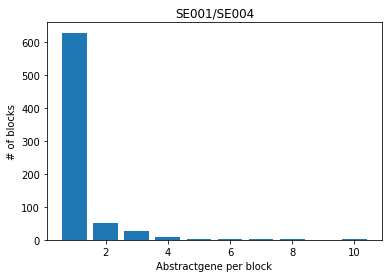

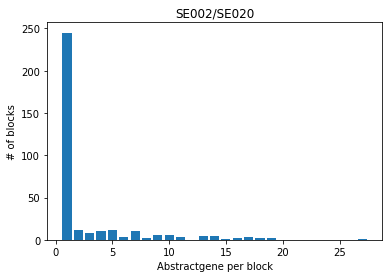

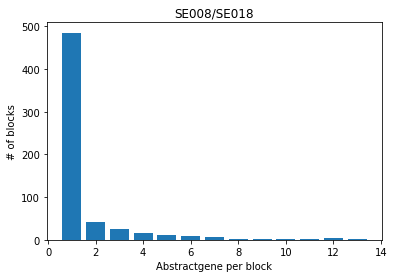

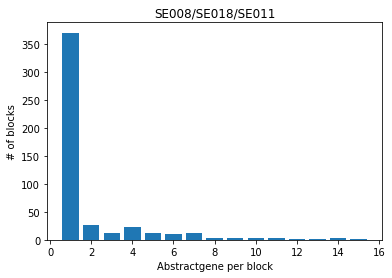

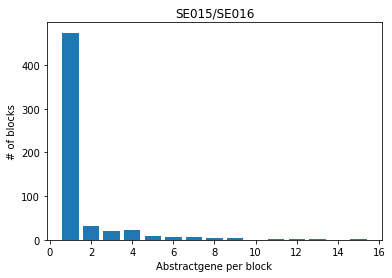

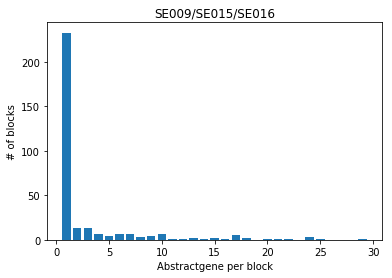

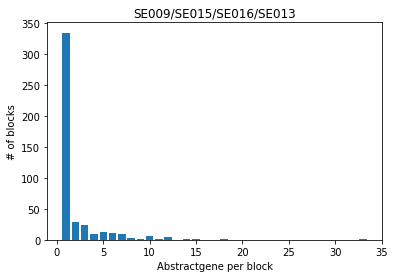

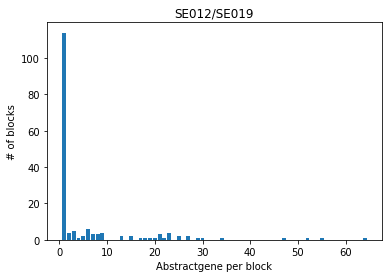

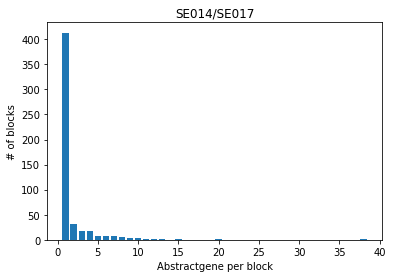

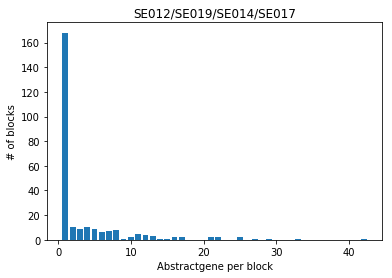

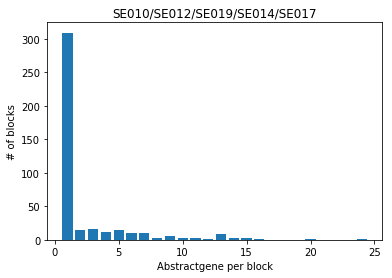

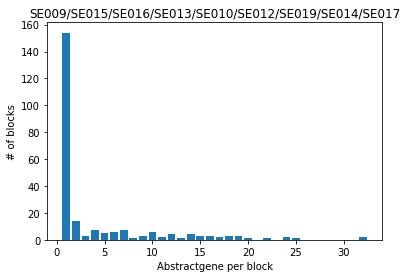

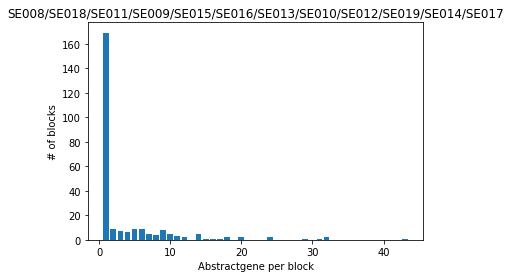

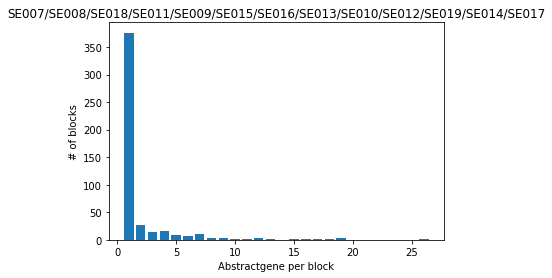

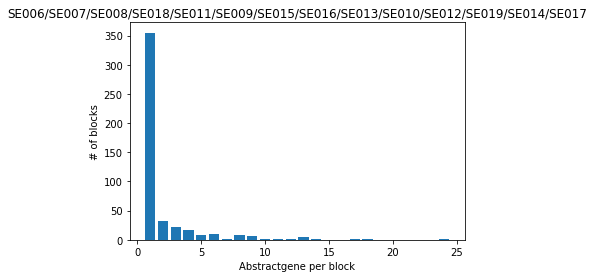

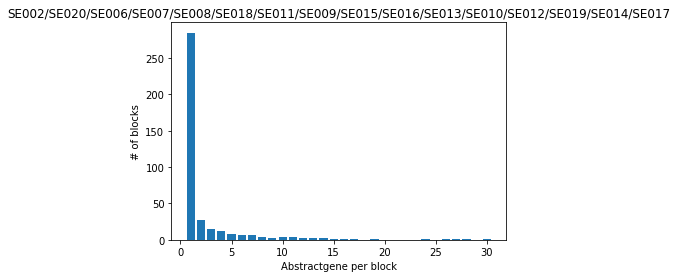

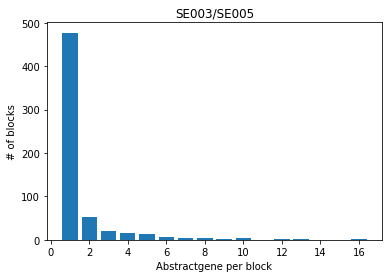

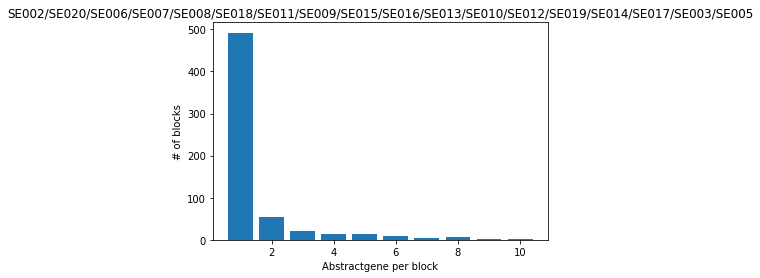

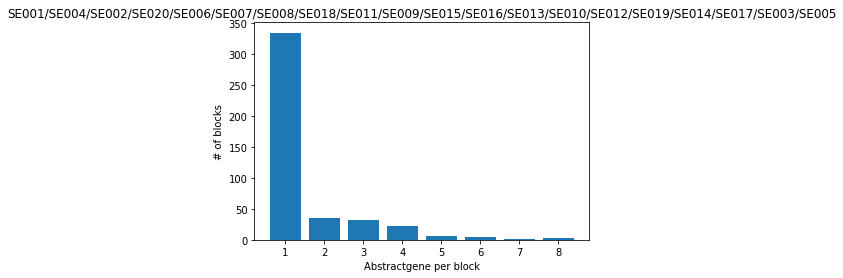

In [76]:
for node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
    assign_neighbors(node.genome)
    get_synteny_blocks(node.genome)
    
    ### Plot ###
    if isinstance(node.genome, pyham.AncestralGenome):
        title = node.genome.name
        raw_values = [len(block) for block in node.genome.synteny]
        label = list(set(raw_values))
        values = [0 for i in range(len(label))]
        for i in range(len(label)):
            for element in raw_values:
                if label[i] == element:
                    values[i] += 1
             
        plt.bar(list(label), values)
        plt.title(title)
        plt.xlabel('Abstractgene per block')
        plt.ylabel('# of blocks')
        plt.show()